# 2 Model Benchmarking
Hyperparameter tuning & preliminary evaluation of different models, using the entire dataset.

Notes:
* XGBoost was trained on tuned parameters using only 100,000 (ca. 1/5th of the data) observations
* SVR and RandomForest had too long a run time and sometimes stalled in the tuning process for 1/5th of the data and were therefore not considered in this iteration.

In [12]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import random

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.exceptions import FitFailedWarning
import xgboost as xgb
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model

import pickle


sns.set(font_scale=0.6)
warnings.filterwarnings('ignore', category=FitFailedWarning)

### Loading, sampling, scaling the data

In [2]:
# load data into df
path = 'data/Dataset-PT.csv'
df = pd.read_csv(path, header=1)

In [3]:
# create further columns, with combined variables
df['upstream_delay_incl_dwell'] = df['upstream_stop_delay'] + df['dwell_time']
df['dwell_incl_origin'] = np.abs(df['previous_bus_delay'] - df['origin_delay'])

In [4]:
# subsample the data given very long execution times for some models
df_sample = df.copy()

In [5]:
# split data into testing and training
X = df_sample[['scheduled_travel_time','previous_bus_delay','previous_trip_travel_time',
'recurrent_delay', 'upstream_delay_incl_dwell']]
y = df_sample['arrival_delay']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Data exploration and visualisation

In [6]:
# Function which takes a model and parameters as input, finds the best set of hyperparameters,
# fits the model, and saves evaluation metrics to a DataFrame
def find_params_and_fit_model(name, model, params, output_df):
    print(f"Computing {name} model:")

    # no params to sample for linear regression
    if name == 'linear':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # else perform RandomizedSearch to sample random params and find the best ones
    else:
        random_search = RandomizedSearchCV(
            model,
            param_distributions=params,
            n_iter=100,
            scoring='neg_mean_squared_error',
            cv=5, verbose=1, random_state=42, n_jobs=-1
        )

        random_search.fit(X_train, y_train)

        print("Best parameters from RandomizedSearchCV: ", random_search.best_params_)
        best_model = random_search.best_estimator_
        y_pred = best_model.predict(X_test)


    # run evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'DecisionTreeRegressor MAE: {mae:.4f}')
    print(f'DecisionTreeRegressor MSE: {mse:.4f}')
    print(f'DecisionTreeRegressor RMSE: {rmse:.4f}')
    print(f'DecisionTreeRegressor R2: {r2:.4f}')

    # plot simple predicted vs real plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs. Predicted Values")
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
    plt.show()

    # save values in df
    output_df.loc[len(output_df)] = [
          {name},
          '-' if name == 'linear' else random_search.best_params_,
          mae,
          mse,
          rmse,
          r2
    ]

    return output_df, model if name == 'linear' else best_model

In [7]:
# Define output_df to save values in
output_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'MAE', 'MSE', 'RMSE', 'R2'])

Computing linear model:
DecisionTreeRegressor MAE: 12.5266
DecisionTreeRegressor MSE: 383.6158
DecisionTreeRegressor RMSE: 19.5861
DecisionTreeRegressor R2: 0.9895


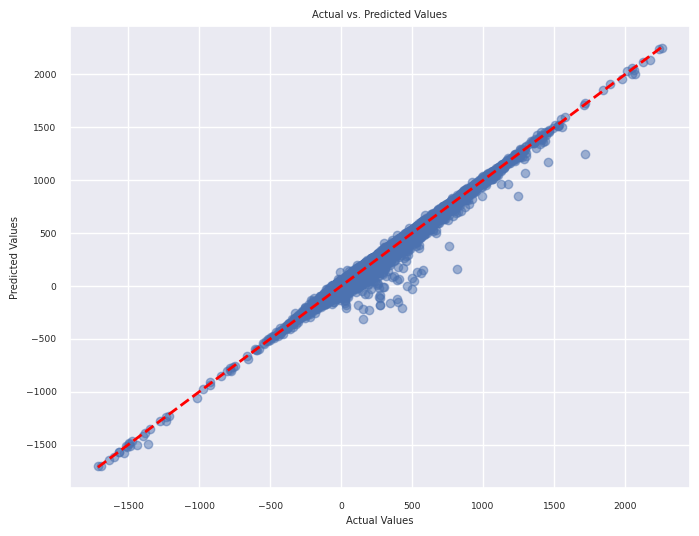

In [8]:
output_df, model_linear = find_params_and_fit_model('linear', LinearRegression(), None, output_df)

**Runtime: 1s**

In [13]:
# Saving the model
with open('models/linear_regression.pkl', 'wb') as f:
    pickle.dump(model_linear, f)

Computing Decision Tree model:
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [  -631.33919425             nan  -3397.45740264   -895.0764418
 -34937.9514892              nan             nan             nan
 -34937.9514892  -11715.67831562  -2694.39367382   -630.6761838
  -3286.06954601 -13927.48775107   -725.02009594  -2086.23663025
 -19024.69648322   -636.62730881   -482.60492131  -8514.8571929
             nan             nan  -5981.82136428             nan
             nan -34937.9514892   -7207.25787198  -2694.39367382
   -725.01118637             nan   -913.38830012   -626.02967281
   -743.88787499             nan  -8513.55406069  -1654.34772556
  -1148.9901055   -1069.20257227  -7209.73000906 -33671.44246165
  -1975.10659688  -3375.70933621             nan             nan
             nan   -624.94965963 -34937.9514892              nan
 -11180.58645453   -743.88724017   -894.23370126 -13927.48775107
   -776.0298982  

Best parameters from RandomizedSearchCV:  {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': None, 'criterion': 'friedman_mse'}
DecisionTreeRegressor MAE: 13.5966
DecisionTreeRegressor MSE: 450.0608
DecisionTreeRegressor RMSE: 21.2146
DecisionTreeRegressor R2: 0.9876


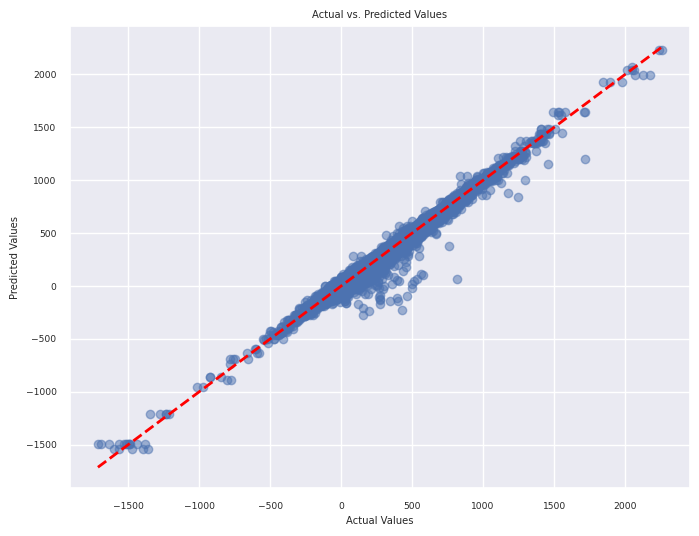

In [14]:
output_df, model_dt = find_params_and_fit_model(
    'Decision Tree',
    DecisionTreeRegressor(random_state=42),
    {
        'criterion': ["squared_error", "friedman_mse"],
        'splitter': ['best', 'random'],
        'max_depth': [2, 4, 8, 24, 48, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 4, 8],
        'max_features': ['auto', 'sqrt', 'log2', None],

    },
    output_df)

**Runtime: 240s**

In [15]:
with open('models/decision_tree.pkl', 'wb') as f:
    pickle.dump(model_dt, f)

Computing XGBoost model:
Best parameters from previous RandomizedSearchCV (using only 100,000 observations):  'subsample': 1, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 4, 'eta': 0.075
DecisionTreeRegressor MAE: 14.1621
DecisionTreeRegressor MSE: 915.8087
DecisionTreeRegressor RMSE: 30.2623
DecisionTreeRegressor R2: 0.9748


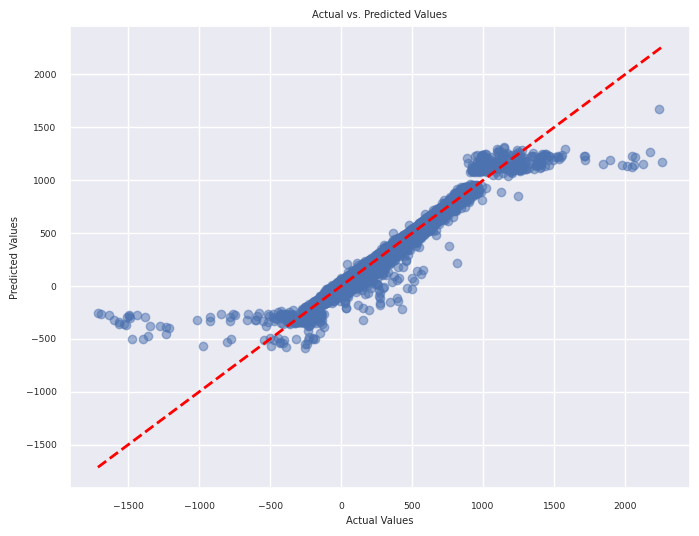

In [18]:
# XGBoost ran for longer than 30m, thus tuned parameters from version with 100000 rows are used to train the model

print(f"Computing XGBoost model:")
print("Best parameters from previous RandomizedSearchCV (using only 100,000 observations): ", "'subsample': 1, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 4, 'eta': 0.075")

model_xgb = xgb.XGBRegressor(subsample= 1, min_child_weight= 1, max_depth= 4, gamma= 4, eta= 0.075,random_state=42)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

# run evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f'DecisionTreeRegressor MAE: {mae:.4f}')
print(f'DecisionTreeRegressor MSE: {mse:.4f}')
print(f'DecisionTreeRegressor RMSE: {rmse:.4f}')
print(f'DecisionTreeRegressor R2: {r2:.4f}')

# plot simple predicted vs real plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
plt.show()

# save values in df
output_df.loc[len(output_df)] = ['XGBoost', "'subsample': 1, 'min_child_weight': 1, 'max_depth': 4, 'gamma': 4, 'eta': 0.075", mae, mse, rmse, r2]

**Runtime:**

* RandomisedSearchCV: 30minutes+
* Fitting the model: 8s

In [22]:
model_xgb.save_model('models/xgboost.json')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


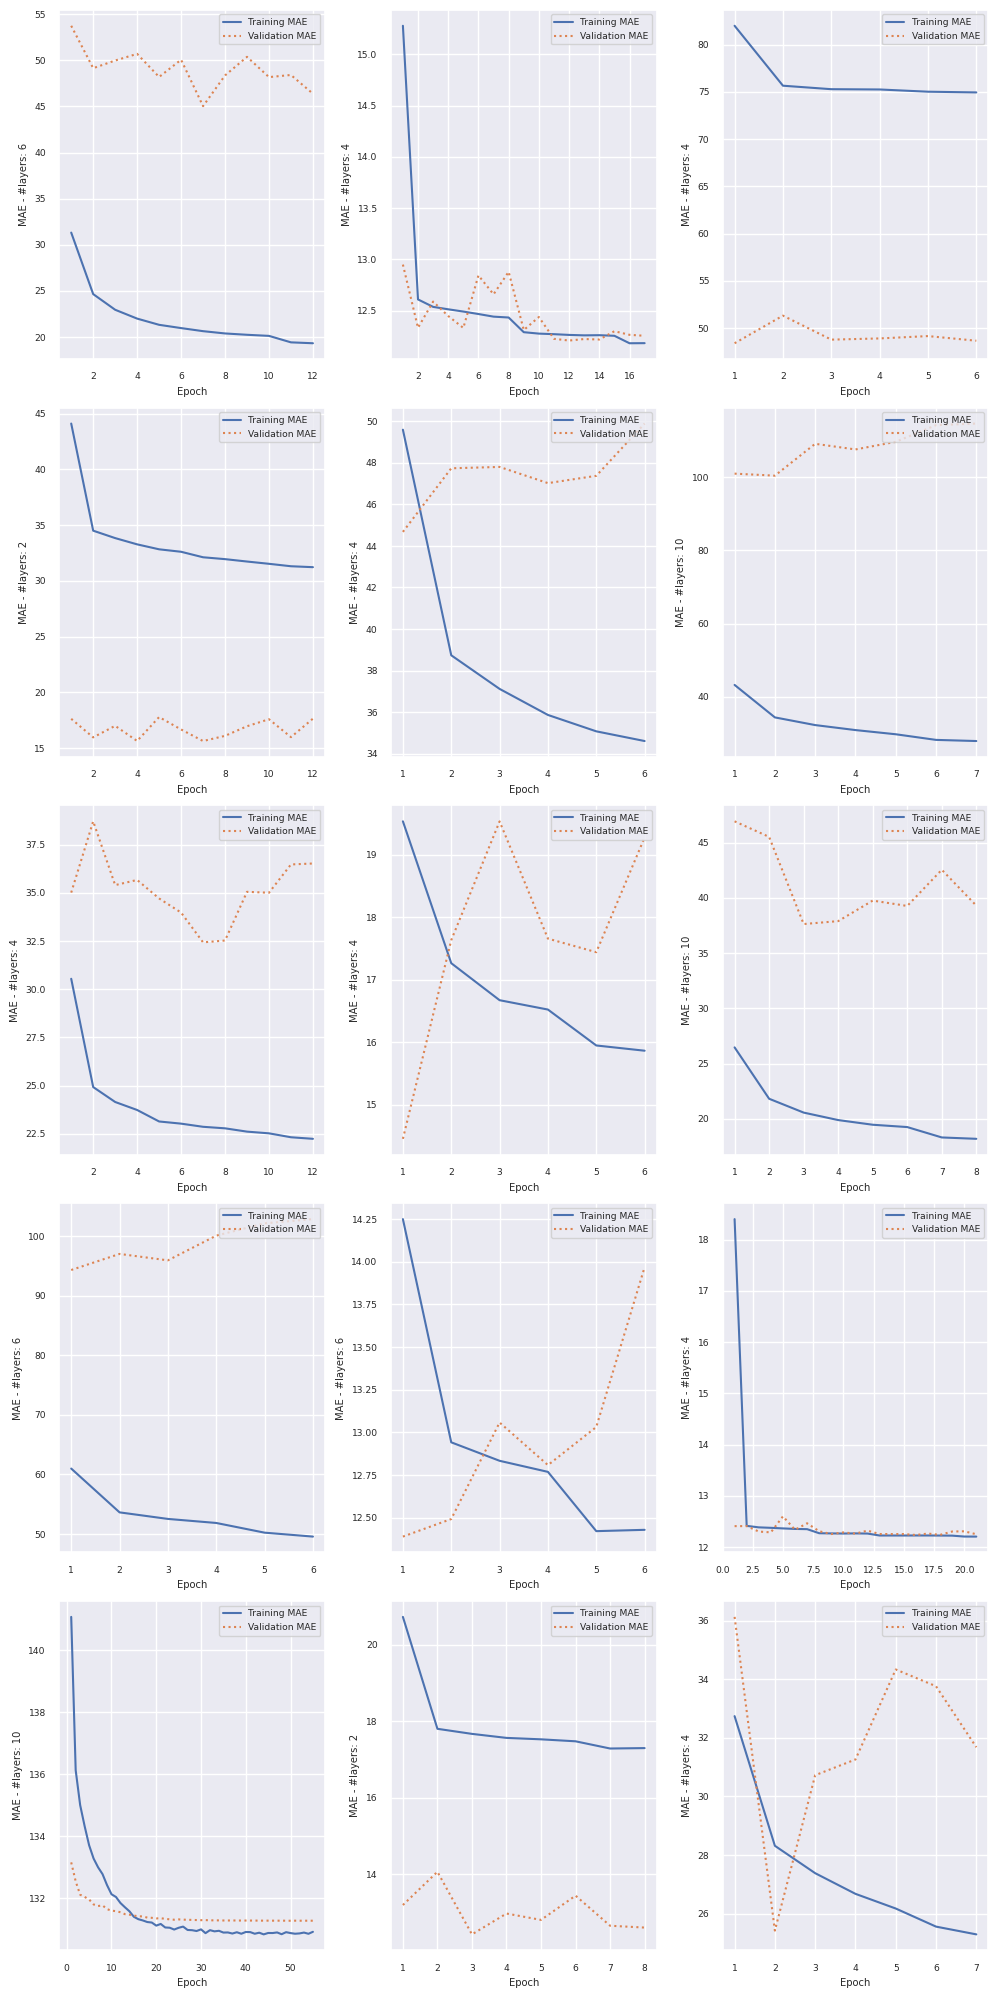

In [19]:
fig, ax = plt.subplots(5, 3, figsize=(10, 20))
output_df_nn = pd.DataFrame(columns=['n_layers', 'neuron_config', 'dropout_rate', 'MAE', 'MSE', 'R2'])

# variables to vary:
nn_params = {
    'n_layers': [2, 4, 6, 10],
    'n_neurons': [4, 8, 32, 64, 128],
    'dropout_rate': [0, 0.1, 0.2, 0.5],
}

# try 10 different random configurations
for iter in range(15):

    # randomly sample parameters
    sampled_params = dict()
    for param, vals in nn_params.items():
      sampled_params[param] = random.choice(vals)

    n_dimensions = X_train.shape[1]

    # model construction
    model = Sequential()
    neuron_config = []

    for layer in range(sampled_params['n_layers']):
      curr_n_neurons = int(sampled_params['n_neurons']*random.choice([0.5, 1, 2]))
      neuron_config.append(curr_n_neurons)

      if layer == 0:
        model.add(Dense(curr_n_neurons, activation='relu', input_dim=n_dimensions))
      else:
        model.add(Dense(curr_n_neurons, activation='relu'))

      model.add(Dropout(sampled_params['dropout_rate']))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics=['mae'])

    # model training
    early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)
    filepath = "weights.best.h5.keras"
    checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=0, save_best_only=True, mode='min')
    hist = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)

    # model evaluation
    err = hist.history['mae']
    val_err = hist.history['val_mae']
    epochs = range(1, len(err) + 1)
    ax[int(iter/3), (iter % 3)].plot(epochs, err, '-', label='Training MAE')
    ax[int(iter/3), (iter % 3)].plot(epochs, val_err, ':', label='Validation MAE')
    ax[int(iter/3), (iter % 3)].set_xlabel('Epoch')
    ax[int(iter/3), (iter % 3)].set_ylabel('MAE - #layers: '+ str(sampled_params['n_layers']))
    ax[int(iter/3), (iter % 3)].legend(loc='upper right')

    # Use the trained model to predict on the test data.
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    output_df_nn.loc[len(output_df_nn)] = [
        sampled_params['n_layers'],
        neuron_config,
        sampled_params['dropout_rate'],
        mae,
        mse,
        r2
    ]


fig.tight_layout()

In [20]:
# Accuracies and neuron configurations for NN
output_df_nn.sort_values(by='R2', ascending=False)

,n_layers,neuron_config,dropout_rate,MAE,MSE,R2
1,4,"[16, 64, 64, 32]",0.0,12.170830,385.924502,0.989397
11,4,"[8, 8, 16, 8]",0.0,12.210465,397.469383,0.989080
10,6,"[128, 32, 32, 128, 128, 64]",0.0,12.357573,409.656952,0.988745
13,2,"[128, 128]",0.2,12.431364,410.496718,0.988722
7,4,"[256, 256, 64, 128]",0.1,14.450797,462.790975,0.987285
3,2,"[16, 16]",0.2,15.677306,579.063426,0.984090
14,4,"[32, 32, 128, 32]",0.2,25.529432,1491.801349,0.959013
6,4,"[32, 16, 64, 64]",0.2,32.600200,2630.176302,0.927736
8,10,"[64, 128, 64, 64, 64, 32, 32, 32, 128, 64]",0.1,37.732141,4045.943198,0.888838
4,4,"[8, 4, 4, 16]",0.1,45.004106,4629.089929,0.872816


In [23]:
# model construction from best parameter in order to be saved and used further
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# model training
early_stop = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor=0.5, patience=3)
filepath = "weights.best.h5.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_mae', verbose=0, save_best_only=True, mode='min')
hist = model.fit(X_train, y_train, validation_split=0.2, epochs=200, batch_size=32, callbacks=[early_stop, reduce_lr,checkpoint],verbose=0)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3118/3118 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


**Runtime:**


*   Hyperparameter tuning: 1h57m
*   Model training: 4m42s



In [21]:
# Add best perfoming model to general output df
best_index = 1
output_df.loc[len(output_df)] = [
          {'neural net'},
          '{n_layers: ' + str(output_df_nn.iloc[best_index].n_layers) + ', neuron_config: ' + str(output_df_nn.iloc[best_index].neuron_config) + ', dropout_rate: ' + str(output_df_nn.iloc[best_index].dropout_rate) + '}',
          output_df_nn.iloc[best_index].MAE,
          output_df_nn.iloc[best_index].MSE,
          np.sqrt(output_df_nn.iloc[best_index].MSE),
          output_df_nn.iloc[best_index].R2
    ]
output_df.sort_values(by='R2', ascending=False)

,Model,Best Parameters,MAE,MSE,RMSE,R2
0,{linear},-,12.526640,383.615754,19.586111,0.989460
3,{neural net},"{n_layers: 4, neuron_config: [16, 64, 64, 32],...",12.170830,385.924502,19.644961,0.989397
1,{Decision Tree},"{'splitter': 'random', 'min_samples_split': 2,...",13.596583,450.060811,21.214637,0.987635
2,XGBoost,"'subsample': 1, 'min_child_weight': 1, 'max_de...",14.162097,915.808684,30.262331,0.974838


In [25]:
model.save('models/neural_net.keras')